Here, we need to clarify that we focus on incompressible material and the algorithm in Bugnicourt(2017) set $\nu=0.5$. We have data with $\nu=0.4$, we can see the result is really bad till now:

In [59]:
### This script is for the Maxwell multi-branch model.
### Deduce process is in generalized_Maxwell_backward_Euler.ipynb
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
#define input parameters
##time
t0 = 0
t1 = 10 #If we do a long-term, say 10 seconds, we expect to see the slope change from 1/tau1 to 1/tau2 then to zero
time_steps = 1000
dt = (t1 - t0)/time_steps
##load(constant)
W = 1e0  # Total load

#domain size
#R = 1  # Radius of demi-sphere
L = 2  # Domain size
Radius = 0.1 # Radius of contact area, here we apply a smaller radius to reduce the effect of periodicity
S = L**2  # Domain area

# Generate a 2D coordinate space
n = 1024
m = 1024

x, y = np.meshgrid(np.linspace(0, L, n, endpoint=False), np.linspace(0, L, m, endpoint=False))

x0 = 1
y0 = 1

E = 3  # Young's modulus
nu = 0.4
E_star = E / (1 - nu**2)  # Plane strain modulus

In [60]:
G_inf = 2.75
G = [2.75]#[2.75, 2.75]

print('G_inf:', G_inf, ' G: ' + str(G))

tau = [1]#[0.1, 1] #relaxation time
eta = [g * t for g, t in zip(G, tau)]

print('tau:', tau, ' eta: ' + str(eta))

G_inf: 2.75  G: [2.75]
tau: [1]  eta: [2.75]


#### Hertz contact theory reference

In [61]:
##Hertz solution at t0 
G_maxwell_t0 = 0
for k in range(len(G)):
    G_maxwell_t0 += G[k]
G_effective_t0 = G_inf + G_maxwell_t0
E_effective_t0 = 2*G_effective_t0*(1+nu)/(1-nu**2)

p0_t0 = (6*W*(E_effective_t0)**2/(np.pi**3*Radius**2))**(1/3)
a_t0 = (3*W*Radius/(4*(E_effective_t0)))**(1/3)
##Hertz solution at t_inf
E_effective_inf = 2*G_inf*(1+nu)/(1-nu**2)

p0_t_inf = (6*W*(E_effective_inf)**2/(np.pi**3*Radius**2))**(1/3)
a_t_inf = (3*W*Radius/(4*(E_effective_inf)))**(1/3)

In [62]:
# define the update function for the animation
def update(frame):
    ax.clear()
    ax.set_xlim(0, L)
    ax.set_ylim(0, 1.1*p0_t0)
    ax.grid()

    # draw Hertzian contact theory reference
    ax.plot(x[n//2], p0_t0*np.sqrt(1 - (x[n//2]-x0)**2 / a_t0**2), 'g--', label='Hertz at t=0')
    ax.plot(x[n//2], p0_t_inf*np.sqrt(1 - (x[n//2]-x0)**2 / a_t_inf**2), 'b--', label='Hertz at t=inf')

    # draw numerical solution at current time step
    ax.plot(x[n//2], pressure_distributions[frame], 'r-', label='Numerical')
    ax.set_title(f"Time = {t0 + frame * dt:.2f}s")
    plt.xlabel("x")
    plt.ylabel("Pressure distribution")
    plt.legend()


In [63]:
#load history from Week16
Ac = np.load('Ac_10seconds_nu04.npy')
pressure_distributions = np.load('pressure_distributions_10seconds_nu04.npy')

In [64]:

Ac_hertz_t0 = np.pi*a_t0**2
Ac_hertz_t_inf = np.pi*a_t_inf**2

print("Analytical contact area radius at t0:", a_t0)
print("Analytical contact area radius at t_inf:", a_t_inf)
print("Analytical maximum pressure at t0:", p0_t0)
print("Analytical maximum pressure at t_inf:", p0_t_inf)
print("Numerical contact area at t0:", Ac[0])
print("Numerical contact area at t_inf",  Ac[-1])
print("Analyical contact area at t0:", Ac_hertz_t0)
print("Analyical contact area at t_inf:", Ac_hertz_t_inf)

Analytical contact area radius at t0: 0.15993368463921528
Analytical contact area radius at t_inf: 0.20150381586419566
Analytical maximum pressure at t0: 18.66644008330305
Analytical maximum pressure at t_inf: 11.759120393777462
Numerical contact area at t0: 0.07724380493164062
Numerical contact area at t_inf 0.12172317504882812
Analyical contact area at t0: 0.08035811827568212
Analyical contact area at t_inf: 0.1275605614850028


In [65]:
# Calculate the slope of the tangent line at the first time step
slope_t0 = (Ac[1] - Ac[0]) / dt

# Calculate the slope of the tangent line at the last time step
slope_t1 = (Ac[-1] - Ac[-2]) / dt

#### Reference with Classical solutions for non-adhesive elastic contact

Here at $t_0$, when the contact area haven't change too much, we can expect the slope of the tangent line at the first time step could fit the analytical slope(reference).

The radius of the contact area for non-adhesive elastic material is given by:

$$
a=\left(\frac{3 P R}{4 E^*}\right)^{\frac{1}{3}}
$$

Then the contact area will be:

$$
A=\pi a^2=\pi\left(\frac{3 P R}{4 E^*}\right)^{\frac{2}{3}}
$$

Now, we introduce $E^*(t)$ for viscoelastic:

$$
A(t)=\pi\left(\frac{3 P R}{4 E^*(t)}\right)^{\frac{2}{3}} \quad \text { for } t \ll \tau \text {(short time)}
$$

And we can express $E^*(t)$ as:
$$
E^*(t)=E_{\infty}^*+\left(E_0^*-E_{\infty}^*\right) e^{-\frac{t}{\tau}}
$$

where $E^*(t=0)=E_0^*$, $E^{* \prime}(t)=-\frac{E_0^*-E_{\infty}^*}{\tau} e^{-\frac{t}{\tau}}, E^*(0)=\frac{E_{\infty}^*-E^*_0}{\tau}$

Then, the analytical slope at $t_0$ should be:

$$
\begin{aligned}
A^{\prime}(t) & =\pi\left(\frac{3 P R}{4}\right)^{\frac{2}{3}}\left(\left(E^*(t)\right)^{-\frac{2}{3}}\right)^{\prime} \\
& =\pi\left(\frac{3 P R}{4}\right)^{\frac{2}{3}} \cdot\left(-\frac{2}{3}\right) \cdot E^{* \prime}(t) \cdot\left(E^*(t)\right)^{-\frac{5}{3}}
\end{aligned}
$$

with $E^{* \prime}(0)=E^*(0)=\frac{E_{\infty}^*-E^*_0}{\tau}$

$$
A^{\prime}(0) \approx \pi \cdot\left(\frac{3 P R}{4}\right)^{\frac{2}{3}} \cdot \frac{2}{3}\left(\frac{E_0^*-E_{\infty}^*}{\tau}\right) \cdot E_0^{-\frac{5}{3}}
$$

where $\frac{E_0^*-E_{\infty}^*}{\tau} \approx \frac{1}{\tau}$ at $t=t_0$

In [66]:
##### One branch case
# Caluculate the reference slope
P = W # total presseure, not pressure distribution
E_0 = 2 * (G[0]+G_inf) * (1 + nu)
slope_t0_ref = np.pi * (3*P*Radius/4)**(2/3) * (2/3) * ((E_effective_t0-E_effective_inf)/tau[0]) * E_effective_t0**(-5/3)

##### Add reference contact area with viscoelastic modulus

We know for short time $( t \ll \tau )$, we have:

$$
A(t)=\pi\left(\frac{3 P R}{4 E^*(t)}\right)^{\frac{2}{3}} 
$$

And we can express $E^*(t)$ as:
$$
E^*(t)=E_{\infty}^*+\left(E_0^*-E_{\infty}^*\right) e^{-\frac{t}{\tau}}
$$


In [67]:
Ac_visco_ref = []
for t in np.arange(t0, t1, dt):    
    E_star_visco = E_effective_inf + (E_effective_t0 - E_effective_inf)*np.exp(-t/tau[0])
    Ac_visco_ref.append(np.pi * (3*P*Radius/4/E_star_visco)**(2/3))

#### Johnson(1985) Reference

By formula (6.63), Johnson(1985) gives a analytical solution for variation of contact radius in two sphere contact:

$$
a^3(t)=\frac{3}{8} R P_0\left\{\frac{1}{g_1}+\frac{1}{g_2}\left(1-\mathrm{e}^{-t / \tau }\right)\right\}
$$


The equations are the same as for a sphere in contact with a half plane except that the effective radius $R$ is defined as $\frac{1}{R}=\frac{1}{R_1}+\frac{1}{R_2}$, such that here we just use $R$ for simplification. This analytical solution is based on a Kelvin model with two springs of modulus $g_1$, and $g_2$ together with a dashpot of viscosity $\eta$ connected as Fig. 6.20 in Johnson(1985):

![](figures/Fig_6_20_Simple_viscoelastic_materials_which_display.png)

When we apply an instantaneous elastic response, it gives a contact radius $a_0=\left(3 R P_0 / 8 g_1\right)^{1 / 3}$, and the contact size grows with time and eventually approaches $a_1=\left\{3 R P_0\left(1 / g_1+1 / g_2\right) / 8\right\}^{1 / 3}$.


Since this analytical solution is based on Standard linear solid model with Kelvin representation, we can apply it for Generalized Maxwell model with one maxwell branch if we find the relationship of shear moduli between these two models.

We keep the parameter $g_1$ and $g_2$ for shear moduli of Standard linear solid model with Kelvin representation as shown in the figure above, and use $G_\infty$ and $G_1$ for shear moduli of Generalized Maxwell model with one maxwell branch. A Generalized Maxwell model should be:

![](figures/Generalized_Maxwell_Model.png)

To find the relationship between these parameters, we should focus on the response of these two models at $t_0$ and $t_\infty$, we use $G^e$ for effective shear modulus:

For Standard linear solid model with Kelvin representation:

$$
\begin{aligned}
& t_0 \rightarrow G^e=g_1 \\
& t_1 \rightarrow \frac{1}{G^e}=\frac{1}{g_1}+\frac{1}{g_2}
\end{aligned}
$$


For Generalized Maxwell model with one maxwell branch:

$$
\begin{aligned}
& t_0 \rightarrow G^e=G_1+G_{\infty} \\
& t_1 \rightarrow G^e=G_{\infty}
\end{aligned}
$$

Then we have the following equation:

$$
\left\{\begin{array}{l}
G_1+G_{\infty}=g_1 \\
G_{\infty}=\frac{g_1 g_2}{g_1+g_2}
\end{array}\right.
$$

Finally we can use $G_1$ and $G_\infty$ in formula (6.63) of Johnson(1985) to replace $g_1$ and $g_2$:

$$
\left\{\begin{array}{l}
g_1=2(G_1+G_{\infty}) \\
g_2=G_{\infty}+\frac{G_{\infty}^2}{G_1}
\end{array}\right.
$$


We have the analytical solution for viscoelastic contact by Johnson(1985):


$$
A_J(t)=\pi a^2(t)=\pi \cdot \left\{\frac{3}{8} R P_0 \left(\frac{1}{g_1}+\frac{1}{g_2}\left(1-e^{-t/\tau}\right) \right)\right\}^{2 / 3}
$$

where $P_0$ is total pressure.

In [68]:
Ac_Johnson_ref = []
g_1 = 2*(G[0] + G_inf)
g_2 = -g_1*(2*G_inf/(2*G_inf-g_1))
for t in np.arange(t0, t1, dt):        
    Ac_Johnson_ref.append((3/8 * Radius * W * (1/g_1 + 1/g_2*(1-np.exp(-t/tau[0]))))**(2/3)*np.pi)

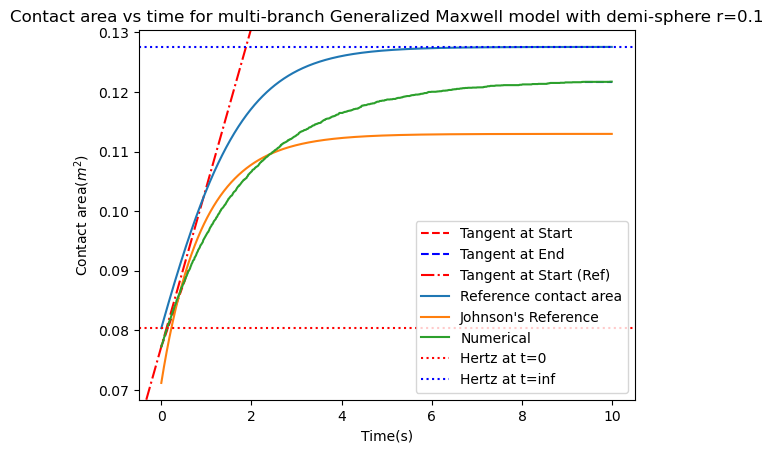

In [69]:
# Define the length of tangent lines
tangent_length = 0.6  # Smaller range for tangent line visualization

# Plot the tangent lines
plt.plot([t0, t0 + tangent_length], [Ac[0], Ac[0] + slope_t0 * tangent_length], 'r--', label='Tangent at Start')
plt.plot([t1 - tangent_length, t1], [Ac[-1] - slope_t1 * tangent_length, Ac[-1]], 'b--', label='Tangent at End')

# Plot the reference tangent lines
plt.axline([t0, Ac[0]], slope=slope_t0_ref, color='r', linestyle='-.',label='Tangent at Start (Ref)')
#plt.axline([t1, Ac[-1]], slope=slope_t1_ref, color='b', linestyle='-.', label='Tangent at End (Ref)')

# Plot the reference contact area vs time
plt.plot(np.arange(t0, t1, dt), Ac_visco_ref)
# Plot the Johnson's solution
plt.plot(np.arange(t0, t1, dt), Ac_Johnson_ref)

plt.plot(np.arange(t0, t1, dt), Ac)
plt.axhline(Ac_hertz_t0, color='red', linestyle='dotted')
plt.axhline(Ac_hertz_t_inf, color='blue', linestyle='dotted')
plt.xlabel("Time(s)")
plt.ylabel("Contact area($m^2$)")
plt.legend(["Tangent at Start", "Tangent at End", "Tangent at Start (Ref)", "Reference contact area", "Johnson's Reference ", "Numerical", "Hertz at t=0", "Hertz at t=inf"])
#define a title that can read parameter tau_0
plt.title("Contact area vs time for multi-branch Generalized Maxwell model with demi-sphere r=0.1")
#plt.axhline(Ac_hertz_t_inf, color='blue')
plt.show()



Then we focus on the slope of contact area curve for Johnson(1985) solution:

$$
A_{\text {Johnson }}^{\prime}(t)=\pi \cdot\left(\frac{3}{8} R P \frac{1}{g_2} \cdot \frac{1}{\tau} \cdot e^{-t / \tau}\right)^{2 / 3}
$$

at $t=0$, we have:

$$
A_{\text {Johnson }}^{\prime}(t=0)=\pi\left(\frac{3}{8} R P \frac{1}{g_2} \cdot \frac{1}{\tau}\right)^{2 / 3}
$$

And 

$$
A_{\text {Johnson }}(t=0)=\pi a_0^2=\pi \cdot\left(\frac{3 R P}{8 g_1}\right)^{2 / 3}
$$

where $g_1=2(G_1+G_{\infty})$

Till now, we found the value of contact area by Johnson(1985) and Classical solutions for non-adhesive elastic contact are the same, but slopes are not, we plan to find why:

For Classical solutions for non-adhesive elastic contact, we have contact area:

$$
A(t=0)=\pi\left(\frac{3 P R}{4 E^*(t)}\right)^{2 / 3}, E^*(t=0)=E_0^*
$$

where we called $E_0^*$ in Hertz solution:

$$
\begin{aligned}
& G_0^*=G_{\infty}+G_0 \\
& E_0^*=2 G_0^* \cdot(1+\nu) /\left(1-\nu^2\right)
\end{aligned}
$$

so finally:

$$
A(t=0)=\pi\left(\frac{3 P R(1-\nu)}{8\left(G_{\infty}+G_0\right)}\right)^{2 / 3}
$$

When we compare with Johnson(1985), we can found for $\nu=0.5$, $g_1=2(G_1+G_{\infty})$, these two reference solution return the same contact area.


And we also have for Classical solutions for non-adhesive elastic contact, we have slope:


$$
A^{\prime}(0) \approx \pi \cdot\left(\frac{3 P R}{4}\right)^{\frac{2}{3}} \cdot \frac{2}{3}\left(\frac{E_0^*-E_{\infty}^*}{\tau}\right) \cdot E_0^{-\frac{5}{3}}
$$

where $\frac{E_0^*-E_{\infty}^*}{\tau} \approx \frac{1}{\tau}$ at $t=t_0$

In [70]:
slope_t0_Johnson_ref = np.pi * (3*P*Radius/8/g_2/tau[0])**(2/3)


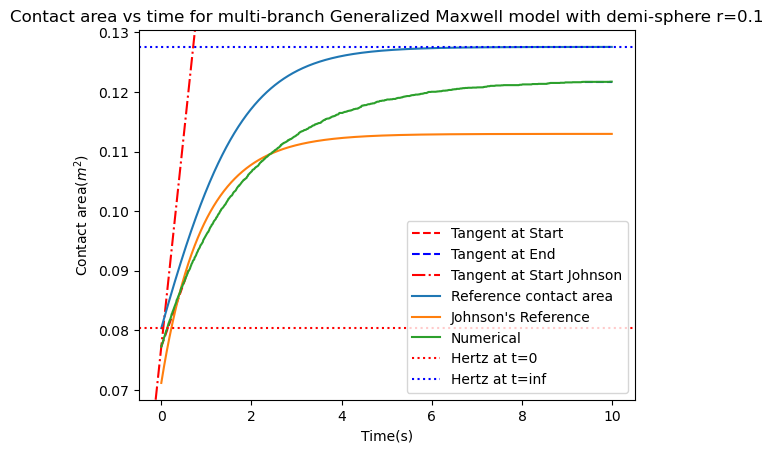

In [71]:

# Plot the tangent lines
plt.plot([t0, t0 + tangent_length], [Ac[0], Ac[0] + slope_t0 * tangent_length], 'r--', label='Tangent at Start')
plt.plot([t1 - tangent_length, t1], [Ac[-1] - slope_t1 * tangent_length, Ac[-1]], 'b--', label='Tangent at End')

# Plot the reference tangent lines
plt.axline([t0, Ac[0]], slope=slope_t0_Johnson_ref, color='r', linestyle='-.')

# Plot the reference contact area vs time
plt.plot(np.arange(t0, t1, dt), Ac_visco_ref)
# Plot the Johnson's solution
plt.plot(np.arange(t0, t1, dt), Ac_Johnson_ref)

plt.plot(np.arange(t0, t1, dt), Ac)
plt.axhline(Ac_hertz_t0, color='red', linestyle='dotted')
plt.axhline(Ac_hertz_t_inf, color='blue', linestyle='dotted')
plt.xlabel("Time(s)")
plt.ylabel("Contact area($m^2$)")
plt.legend(["Tangent at Start", "Tangent at End", "Tangent at Start Johnson", "Reference contact area", "Johnson's Reference ", "Numerical", "Hertz at t=0", "Hertz at t=inf"])
#define a title that can read parameter tau_0
plt.title("Contact area vs time for multi-branch Generalized Maxwell model with demi-sphere r=0.1")
#plt.axhline(Ac_hertz_t_inf, color='blue')
plt.show()

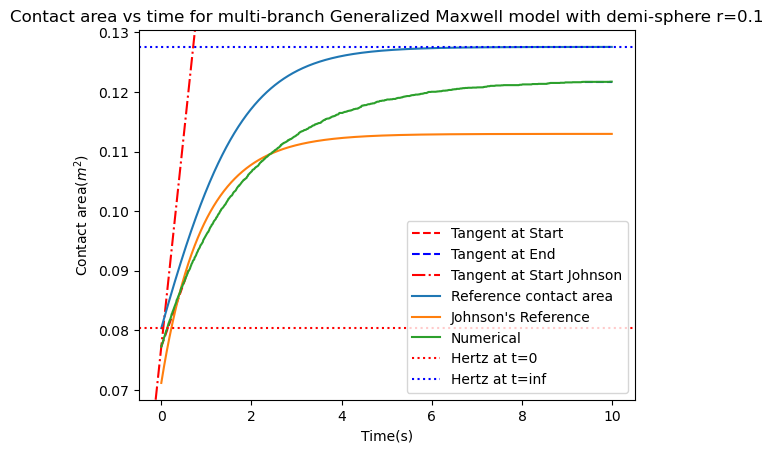

In [72]:
# Plot the tangent lines
plt.plot([t0, t0 + tangent_length], [Ac[0], Ac[0] + slope_t0 * tangent_length], 'r--', label='Tangent at Start')
plt.plot([t1 - tangent_length, t1], [Ac[-1] - slope_t1 * tangent_length, Ac[-1]], 'b--', label='Tangent at End')

# Plot the reference tangent lines
plt.axline([t0, Ac[0]], slope=slope_t0_Johnson_ref, color='r', linestyle='-.')

# Plot the reference contact area vs time
plt.plot(np.arange(t0, t1, dt), Ac_visco_ref)
# Plot the Johnson's solution
plt.plot(np.arange(t0, t1, dt), Ac_Johnson_ref)

plt.plot(np.arange(t0, t1, dt), Ac)
plt.axhline(Ac_hertz_t0, color='red', linestyle='dotted')
plt.axhline(Ac_hertz_t_inf, color='blue', linestyle='dotted')
plt.xlabel("Time(s)")
plt.ylabel("Contact area($m^2$)")
plt.legend(["Tangent at Start", "Tangent at End", "Tangent at Start Johnson", "Reference contact area", "Johnson's Reference ", "Numerical", "Hertz at t=0", "Hertz at t=inf"])
#define a title that can read parameter tau_0
plt.title("Contact area vs time for multi-branch Generalized Maxwell model with demi-sphere r=0.1")
#plt.axhline(Ac_hertz_t_inf, color='blue')
plt.show()